# Краткое описание

Реализована создание графа процесса, матрица вероятностных переходов и отрисовка графа

In [1]:
def rate(self,rate1,rate2):

SyntaxError: unexpected EOF while parsing (<ipython-input-1-a5a70e45fbf3>, line 1)

считает формулу (1)

на вход подаётся количество случаев когда стадия A шла после стадии B и наоборот. Это можно посчитать с помощью функции 

In [2]:
def numbers_of_cases(self,stage1,stage2):

SyntaxError: unexpected EOF while parsing (<ipython-input-2-67f069e09791>, line 1)

где stage1,stage2 название стадий. К примеру, 'Stage_0', 'Stage_1'

In [3]:
def get_a_ensue_b_and_c(self,stage0,stage1,stage2):

SyntaxError: unexpected EOF while parsing (<ipython-input-3-f2ea0146bd8f>, line 1)

считает формулу (4)

на вход подаётся названия стадий 

# Проблема

Как определить в каком отношении находятся стадии графа

Переход от графа процесса к граффу стадий процесса.

# Реализация

In [37]:
import numpy as np
import pandas as pd
from itertools import product as conbinations
import matplotlib.pyplot as plt
from graphviz import Graph
from pm4py.objects.conversion.log import factory as conversion_factory  # преобразование DataFrame в лог-файл
from pm4py.algo.discovery.heuristics import factory as heuristics_miner
from pm4py.visualization.heuristics_net import factory as hn_vis_factory  # отрисовка heu_net

In [38]:
#df=pd.read_csv('dataset_el.csv')
df=pd.read_csv('synthetic_process_mining_dataset5.csv')

print(df.shape)
df.head()

(4461, 3)


,id,stages,dt
0,0.0,Stage_0,2019-12-01
1,0.0,Stage_3,2019-12-02
2,0.0,Stage_5,2019-12-05
3,0.0,Stage_2,2019-12-11
4,0.0,Stage_7,2019-12-17


In [39]:
import time
t = time.time()
CASE_ID_COLNAME = 'id'
ACTIVITY_ID_COLNAME = 'stages'
TIMESTAMP_COLNAME = 'dt'
log = conversion_factory.apply(df, parameters={'case_id_glue': CASE_ID_COLNAME})

parameters = {'pm4py:param:activity_key': ACTIVITY_ID_COLNAME,
                  'dependency_thresh': 0.05,
                  'min_act_count': 1,
                  'min_dfg_occurrences': 1}
heu_net = heuristics_miner.apply_heu(log, parameters=parameters)
gviz_params = {"format": "png"}
               # "splines": "curved",
               # "quadType": "fast",
               # "engine": "neato",
               # "layout": "sfpd"}
name = 'image'
gviz = hn_vis_factory.apply(heu_net, parameters=gviz_params)
hn_vis_factory.save(gviz, 'heu_net_{}.png'.format(name))
print(time.time() - t)

Init 0.0
1 loop 0.0009970664978027344
2 loop 0.0
3 loop 0.004987478256225586
4 loop 0.0019936561584472656
Last loop 0.0009882450103759766

Write graph 0.3686532974243164
0.4135165214538574


In [43]:
class process_mining:
    def __init__(self, df,threshold):
        self.data = df
        self.stages = np.sort(df.stages.unique())
 #       self.stages = np.insert(self.stages,0,"Start")
 #       self.stages = np.insert(self.stages,len(self.stages),"End")    
        self.l = self.stages.shape[0]
        self.matrix = np.zeros((self.l,self.l))        
        self.bin_matrix = np.ones((self.l,self.l))
#        self.bin_matrix[0] = 0
#        mat[len(mat)-1][len(mat)-1] = 0

        self.indexs = []
        self.initial_state = ''
        self.initial_index = 0
        self.threshold = threshold
        self.id = pd.unique(df['id']) 
    #считает количетсво случаев когда stage1 идёт после stage2 и наоборот  
    def numbers_of_cases(self,stage1,stage2):
        ar_1=self.data[(self.data.stages==stage1)]
        ar_2=self.data[(self.data.stages==stage2)]
        ar=ar_1.merge(ar_2,left_on='id', right_on='id')        
        #1 значение - кол-во идущих после
        #2 значение - кол-во идущих раньше
        return [ar[ar.dt_x>ar.dt_y].shape[0],ar[ar.dt_x<ar.dt_y].shape[0]]

    #считает коэффициент (1) описанный в статье, который нужно записать в матрицу
    def rate(self,rate1,rate2):
        return (rate1-rate2)/(rate1+rate2+1)
        
    #вычисляет матрицу переходных вероятностей
    def matrix_prob(self):
        for i in range(self.l):
            for j in range(self.l):                
                self.matrix[i][j]=self.rate(*self.numbers_of_cases(self.stages[i],self.stages[j]))

        return self.matrix
    
    #бинаризируем по порогуth как в статье
    def matrix_bin(self):
        self.bin_matrix[self.matrix>=self.threshold] = 1
        self.bin_matrix[(self.matrix<self.threshold)] = 0
        return self.bin_matrix
        
    #строим граф по matrix_bin
    def matrix_for_graph(self):
        self.indexs=[]
        index=np.all(self.bin_matrix==0,axis=1)
        self.initial_state=self.stages[index]
        self.initial_index=np.argwhere(index == True)
        self.recur_func(*np.argwhere(index== True))
        return self.indexs
    
    #идём по графу процесса из вершины в вершину по маьрице смежности и записываем название рёбер для отрисовки графа
    def recur_func(self,*nodes):
        nodes_new=[]
        ch=0
        for node in nodes:
            for j in node:
                for i in range(self.l):
                    if(self.bin_matrix[i,j]):
                        ch=1
                        self.indexs.extend([str(j)+str(int(i))])
                        nodes_new.append(i)
                break
        if ch==1:
            self.recur_func(nodes_new)
        else:
            return 0 
    #отрисовка графа
    def graph(self):
        self.matrix_prob()
        self.matrix_bin()
        self.matrix_for_graph()
        
        dot = Digraph(comment='Process')
        
        #nodes        
        #задаём начальную ноду отдельно
        for name, init in zip(self.initial_index,self.initial_state):
            dot.node(str(name[0]),init)
                
        ind=np.any(self.bin_matrix>0,axis=1)
        
        for i in range(self.l):
            if ind[i]:
                dot.node(str(i), self.stages[i])
        
        #edges
        print(self.indexs)
        dot.edges(self.indexs)
        dot.format = 'png'
        dot.render()
        return dot
        
    # get методы для удобной работы
    def get_matrix(self):
        return self.matrix_prob()
    
    def get_matrix_bin(self):
        self.matrix_prob()
        return self.matrix_bin()
    
    def get_matrix_graph(self):
        self.matrix_prob()
        self.matrix_bin()
        return self.matrix_for_graph()
    

In [45]:
import graphviz
ni = graphviz.Graph('ni')

ni.attr('node', shape='rarrow')
for i in range(11):
    ni.node(str(i), 'Ni!')
ni.attr(rankdir='LR')
ni.edges(['12', '23', '34', '45','56','67','78','89','910'])


ValueError: too many values to unpack (expected 2)

0.0010302066802978516
['01', '02', '03', '04', '05', '06', '07', '08', '09', '12', '13', '14', '15', '16', '17', '18', '19', '23', '24', '25', '26', '27', '28', '29', '34', '35', '36', '37', '38', '39', '45', '46', '47', '48', '49', '56', '57', '58', '59', '67', '68', '69', '78', '79', '89']


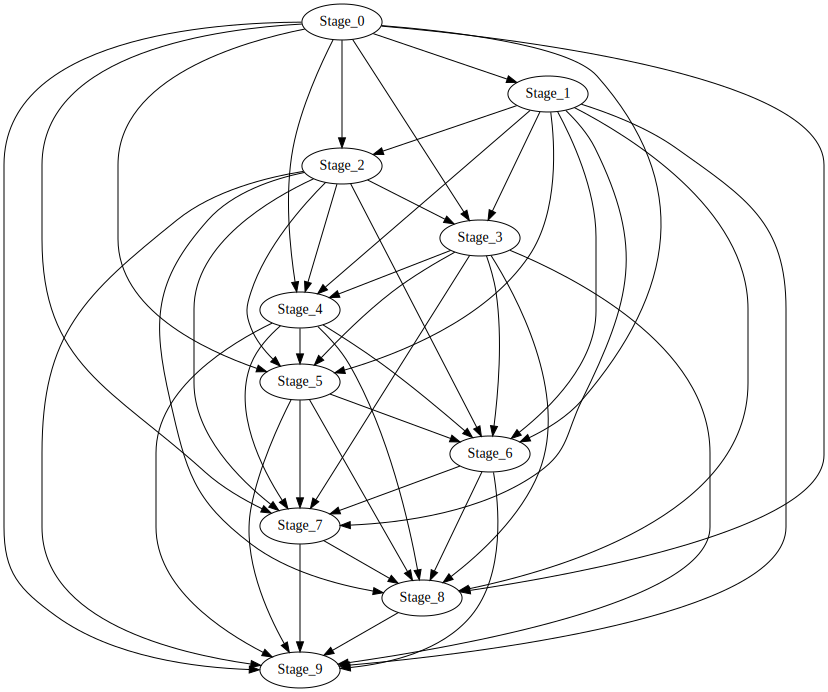

In [44]:
t = time.time()
pm=process_mining(df,0.05)
print(time.time() - t)
pm.graph()

In [24]:
pd.DataFrame(pm.get_matrix())

,0,1,2,3,4,5,6,7,8,9
0,0.000000,-0.670807,-0.732673,-0.825792,-0.895833,-0.926503,-0.964706,-0.976000,-0.981405,-0.993976
1,0.670807,0.000000,-0.682432,-0.869565,-0.909091,-0.932836,-0.958333,-0.990476,-0.976744,-0.975610
2,0.732673,0.682432,0.000000,-0.696429,-0.808333,-0.868106,-0.853333,-0.919881,-0.969977,-0.992754
3,0.825792,0.869565,0.696429,0.000000,-0.648936,-0.686441,-0.857143,-0.882943,-0.937330,-0.961832
4,0.895833,0.909091,0.808333,0.648936,0.000000,-0.712963,-0.450000,-0.876404,-0.915888,-0.962963
5,0.926503,0.932836,0.868106,0.686441,0.712963,0.000000,-0.738462,-0.749186,-0.873385,-0.891304
6,0.964706,0.958333,0.853333,0.857143,0.450000,0.738462,0.000000,-0.685185,-0.723684,-0.941176
7,0.976000,0.990476,0.919881,0.882943,0.876404,0.749186,0.685185,0.000000,-0.755700,-0.930693
8,0.981405,0.976744,0.969977,0.937330,0.915888,0.873385,0.723684,0.755700,0.000000,-0.744526
9,0.993976,0.975610,0.992754,0.961832,0.962963,0.891304,0.941176,0.930693,0.744526,0.000000


In [7]:
strin = '''id,stages,dt
case 1,activity A,9-3-2004:15.01
case 2,activity A,9-3-2004:15.12
case 3,activity A,9-3-2004:16.03
case 3,activity B,9-3-2004:16.07
case 1,activity B,9-3-2004:18.25
case 1,activity C,10-3-2004:9.23
case 2,activity C,10-3-2004:10.34
case 4,activity A,10-3-2004:10.35
case 2,activity B,10-3-2004:12.34
case 2,activity D,10-3-2004:12.50
case 5,activity A,10-3-2004:13.05
case 4,activity C,11-3-2004:10.12
case 1,activity D,11-3-2004:10.14
case 3,activity C,11-3-2004:10.44
case 3,activity D,11-3-2004:11.03
case 4,activity B,11-3-2004:11.18
case 5,activity E,11-3-2004:12.22
case 5,activity D,11-3-2004:14.34
case 4,activity D,11-3-2004:15.56'''

In [8]:
data = pd.DataFrame(columns=strin.split('\n')[0].split(','))

In [9]:
for i in range(1,1000):
    try:
        data.loc[i] = strin.split('\n')[i].split(',')[0],strin.split('\n')[i].split(',')[1],strin.split('\n')[i].split(',')[2]
    except:
        break

In [10]:
data.keys()

Index(['id', 'stages', 'dt'], dtype='object')

In [12]:
data['dt'] = pd.to_datetime(data['dt'],format = '%d-%m-%Y:%H.%M')
#data.loc[0]['dt']